# BAGAN MNIST

Цель - синтезировать данные из несбалансированной выборки. 


Другими словами, есть по ~6000 образцов с метками 1,2 .. 9, но всего 148 образцов с меткой 0. Целью является синтез образцов с меткой 0.


Если обучать обычную GAN сеть только на 148 образцах, сеть не обучится из-за малости выборки. 

Если обучать обычную GAN сеть на всех образцах, чтобы она синтезировала данные, похожие на реальные (то есть и 1, и 2, и 3 итд), то в синтезированных данных практически не будет нулей, так как это невыгодно с точки зрения задачи оптимизации. 

Поэтому  используется алгоритм BAGAN, в который входят автокодировщик; conditionl_latent_generator - генератор псевдослучайных векторов на основе распределений для конкретных классов для подачи на вход модели-генератору. Также изменен сам алгоритм GAN: модель-дискриминатор не является бинарным классификатором, различающим real - fake. Теперь это задача многоклассовой классификации, где модель-дискриминатор определяет между fake и 10 реальными классами. 

In [1]:
import torch
import torch.nn as nn


from collections import OrderedDict
import numpy as np
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import sys
import time
import math

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.misc
import torch.distributions.multivariate_normal as mn

import argparse
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

import torch.utils.data as data_utils

random_seed = 99
torch.manual_seed(random_seed)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Directories creation

In [2]:
train_dir = 'training'
checkpoint_dir = 'checkpoint'
distribution_dir = 'distribution'

In [3]:
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
if not os.path.exists(distribution_dir):
    os.mkdir(distribution_dir)


## 2. Data loading

In [4]:
def plot_results(G, fixed_noise, image_size,  is_gray=True):  # for generated data
#     G.eval()
    generate_images = G(fixed_noise.to(DEVICE)).cpu().detach().numpy()
#     G.train()
    
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(generate_images[i][0], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])


In [5]:
def load_data():
    '''The dataset consists of only 148 "0" samples, 
    which is 2.5% of available "0" samples'''
    print(load_data.__doc__)
    
    dataset = torchvision.datasets.MNIST(train_dir, train = True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))
    idx = (dataset.targets==0)
    dataset.targets = (dataset.train_labels[idx])
    dataset.data = dataset.train_data[idx]
    
    indices = torch.arange(148)
    dataset0 = data_utils.Subset(dataset, indices)
    
    
    
    dataset = torchvision.datasets.MNIST(train_dir, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))


    idx = (dataset.targets != 0)
    dataset.targets = (dataset.train_labels[idx])
    dataset.data = dataset.train_data[idx]
    
    dataset = dataset0 + dataset
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    
    return dataloader

In [6]:
def plot_examples(dataloader):  
    examples = enumerate(dataloader)
    print('examples: ', examples)

    batch_idx, (example_data, example_targets) = next(examples) # is used every time
    # index, data, label
    print('batch_idx = ', batch_idx)
    print('example_data.shape = ', example_data.shape)
    print('example_targets.shape = ', example_targets.shape)


    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')### !!!!!!!
        plt.title("Real: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

In [7]:
def plot_quantity(dataloader):
    Targets = []
    for i,(example_data, example_targets) in enumerate(dataloader):
        example_targets = list(example_targets.numpy())
        for i in example_targets:
            Targets.append(i)
    
    d = dict()
    for i in Targets:
        if i not in d:
            d[i] = 1
        else:
            d[i] += 1
       
    d = OrderedDict(sorted(d.items()))
    
    sns.countplot(x = Targets )
    for i, j in d.items():
        print(i, j, sep = ' : ', end = '; ')

In [8]:
batch_size = 128

data_loader = load_data()

The dataset consists of only 148 "0" samples, 
    which is 2.5% of available "0" samples



Extracting training\MNIST\raw\train-images-idx3-ubyte.gz to training\MNIST\raw




Extracting training\MNIST\raw\train-labels-idx1-ubyte.gz to training\MNIST\raw




Extracting training\MNIST\raw\t10k-images-idx3-ubyte.gz to training\MNIST\raw




Extracting training\MNIST\raw\t10k-labels-idx1-ubyte.gz to training\MNIST\raw



C:\Users\zaret\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\zaret\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [9]:
data_loader

examples:  <enumerate object at 0x0000020E1D609228>
batch_idx =  0
example_data.shape =  torch.Size([128, 1, 28, 28])
example_targets.shape =  torch.Size([128])


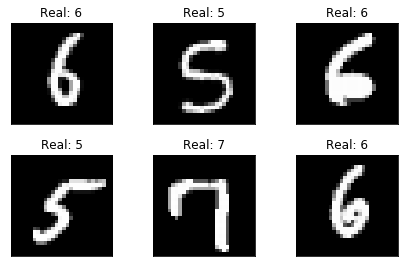

In [10]:
plot_examples(data_loader)

0 : 148; 1 : 6742; 2 : 5958; 3 : 6131; 4 : 5842; 5 : 5421; 6 : 5918; 7 : 6265; 8 : 5851; 9 : 5949; 

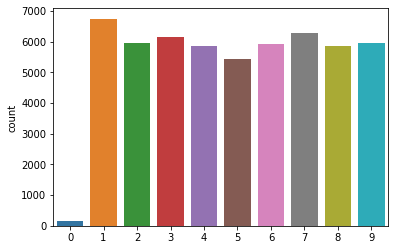

In [11]:
plot_quantity(data_loader)

## 2. Models


In [12]:
#epochs = 500
lr = 1e-3

hidden_size = 32 

latent_dims = hidden_size * 8
class_num = 10

## Generate Distributions:

In [13]:
# Discriminator
class Encoder(nn.Module):   ## changed
    def __init__(self, hidden_dim, latent_dims = latent_dims):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(            
            nn.Conv2d(1, hidden_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_dim * 4, latent_dims, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        output = self.model(x)
        return output.squeeze(-1).squeeze(-1)

In [14]:
# Generator
class Decoder(nn.Module):
    def __init__(self, hidden_dim, latent_dims = latent_dims):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dims, hidden_dim*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim, 1, 4, 2, 1, bias=False),
      )


    def forward(self, z):
        z = z.unsqueeze(-1).unsqueeze(-1)
        output = self.model(z)
        return output

In [18]:
class Discriminator(nn.Module):

    def __init__(self, hidden_dim, latent_dims = latent_dims, output_size = class_num + 1): #!!!!
        super(Discriminator, self).__init__()
        
        self.model = Encoder(hidden_dim)
        self.linear5 = nn.Linear(latent_dims, output_size)
        
    def forward(self, x):
        # flatten image
        #x = x.view(-1, 28 * 28)
        x = self.model(x)
        x = F.leaky_relu(x)
        out = self.linear5(x)

        return out

In [19]:
class PriorDiscriminator(nn.Module):
    def __init__(self,latent_dims=latent_dims):
        super().__init__()
        self.l0 = nn.Linear(latent_dims, 64)
        self.l1 = nn.Linear(64, 64//4)
        self.l2 = nn.Linear(64//4, 1)
        
    def forward(self, x):
        h = F.leaky_relu(self.l0(x))
        h = F.leaky_relu(self.l1(h))
        return torch.sigmoid(self.l2(h))


## 4. Autoencoder
Автокодировщик используется для того, чтобы модели генератора и дискриминатора были уже обученные (pretrained) перед началом основного цикла обучения. Это возможно, так как архитектуры сетей кодировщика и декодировщика совпадают с архитектурами дискриминатора и генератора соответственно. 

Основной причиной использования автокодировщика является получение информации о каждом классе, чтобы генератору (в основном цикле обучения) на вход подавался не просто случайный вектор из latent_space, а "полуслучайный" вектор, который бы соответствовал распределению для конкретного класса.

In [20]:
epochs_autoen = 60

0 : 148; 1 : 6742; 2 : 5958; 3 : 6131; 4 : 5842; 5 : 5421; 6 : 5918; 7 : 6265; 8 : 5851; 9 : 5949; 

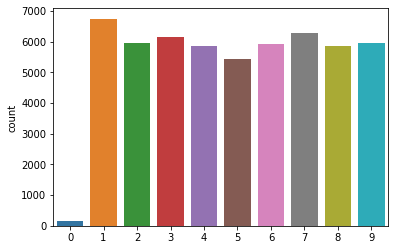

In [22]:
data_loader_autoen = data_loader
plot_quantity(data_loader_autoen)

In [24]:
encoder = Encoder(hidden_dim = hidden_size).to(DEVICE)
decoder = Decoder(hidden_dim = hidden_size).to(DEVICE)
disc = PriorDiscriminator().to(DEVICE)
recon_loss = nn.MSELoss(reduction = 'sum').to(DEVICE)

In [25]:
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=1e-3)
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=1e-3)
optim_encoder_reg = torch.optim.Adam(encoder.parameters(), lr=1e-3)
optim_D = torch.optim.Adam(disc.parameters(), lr=1e-3)

## Adversarial auto encoder
Испольуется метод, аналогичный алгоритму Wasserstein GAN

In [26]:
import torch.autograd as autograd
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_ep = []
losses = []
start_time = time.time()
EPS = 1e-15
one = torch.FloatTensor([1])
mone = one * -1
one = one.to(DEVICE)
mone = mone.to(DEVICE)
for epoch in range(epochs_autoen):
    for i, (x, y) in enumerate(data_loader_autoen):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        batch = x.size(0)
        
        encoder.train()
        decoder.train()
        disc.train()
        
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()
        
        """ Reconstruction phase """
        z = encoder(x)
        x_hat = decoder(z)
        loss = recon_loss(x_hat,x)
        loss.backward()
        optim_encoder.step()
        optim_decoder.step()


        """ Discriminator phase """
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()
        encoder.eval()
        
        z_real_gauss = autograd.Variable(torch.randn(z.size())*10).to(DEVICE)
        z_fake_gauss = encoder(x)
        
        D_real_gauss, D_fake_gauss = disc(z_real_gauss), disc(z_fake_gauss.detach())
        
        real_outputs = D_real_gauss.mean(dim=0)
        real_outputs.backward(mone)
        fake_outputs = D_fake_gauss.mean(dim=0)
        fake_outputs.backward(one)
        optim_D.step()
        
        """ Regularization phase """
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()

        encoder.train()   # Back to use dropout
        z = encoder(x)
        D_fake_gauss = disc(z)
        fake_outputs = D_fake_gauss.mean(dim=0)
        fake_outputs.backward(mone)
        optim_encoder_reg.step()
        
        if epoch > 0 and i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(x), len(data_loader_autoen.dataset),
                100. * i / len(data_loader_autoen), loss.item()))
            
        if (i == len(data_loader_autoen) - 1): # per epoch 
            loss_ep.append(loss.item())
        
        
        losses.append(loss.item())        


    if epoch == 0:
        print("---1 epoch: %s seconds ---" % (time.time() - start_time))

torch.save({'epoch': epoch, 'state_dict': encoder.state_dict(),}, 
           checkpoint_dir + '/encoder.pth')
torch.save({'epoch': epoch, 'state_dict': decoder.state_dict(),}, 
           checkpoint_dir +'/decoder.pth' )

---1 epoch: 143.4466037750244 seconds ---
Train Epoch: 1 [0/54225 (0%)]	Loss: 7668.659180
Train Epoch: 1 [12800/54225 (24%)]	Loss: 8618.201172
Train Epoch: 1 [25600/54225 (47%)]	Loss: 7103.363770
Train Epoch: 1 [38400/54225 (71%)]	Loss: 5859.878418
Train Epoch: 1 [51200/54225 (94%)]	Loss: 5136.656250
Train Epoch: 2 [0/54225 (0%)]	Loss: 4905.672852
Train Epoch: 2 [12800/54225 (24%)]	Loss: 4055.909668
Train Epoch: 2 [25600/54225 (47%)]	Loss: 3871.367188
Train Epoch: 2 [38400/54225 (71%)]	Loss: 4086.345215
Train Epoch: 2 [51200/54225 (94%)]	Loss: 3653.574951
Train Epoch: 3 [0/54225 (0%)]	Loss: 3570.591553
Train Epoch: 3 [12800/54225 (24%)]	Loss: 3144.893799
Train Epoch: 3 [25600/54225 (47%)]	Loss: 3239.068359
Train Epoch: 3 [38400/54225 (71%)]	Loss: 2889.739502
Train Epoch: 3 [51200/54225 (94%)]	Loss: 2694.745361
Train Epoch: 4 [0/54225 (0%)]	Loss: 2663.626465
Train Epoch: 4 [12800/54225 (24%)]	Loss: 2598.233398
Train Epoch: 4 [25600/54225 (47%)]	Loss: 2623.581299
Train Epoch: 4 [38400/54

Train Epoch: 32 [25600/54225 (47%)]	Loss: 502.542969
Train Epoch: 32 [38400/54225 (71%)]	Loss: 427.283386
Train Epoch: 32 [51200/54225 (94%)]	Loss: 444.210358
Train Epoch: 33 [0/54225 (0%)]	Loss: 445.793457
Train Epoch: 33 [12800/54225 (24%)]	Loss: 441.993408
Train Epoch: 33 [25600/54225 (47%)]	Loss: 461.576324
Train Epoch: 33 [38400/54225 (71%)]	Loss: 420.202362
Train Epoch: 33 [51200/54225 (94%)]	Loss: 413.835999
Train Epoch: 34 [0/54225 (0%)]	Loss: 398.642487
Train Epoch: 34 [12800/54225 (24%)]	Loss: 422.629150
Train Epoch: 34 [25600/54225 (47%)]	Loss: 410.630280
Train Epoch: 34 [38400/54225 (71%)]	Loss: 430.464294
Train Epoch: 34 [51200/54225 (94%)]	Loss: 423.104004
Train Epoch: 35 [0/54225 (0%)]	Loss: 422.900421
Train Epoch: 35 [12800/54225 (24%)]	Loss: 416.334381
Train Epoch: 35 [25600/54225 (47%)]	Loss: 413.634003
Train Epoch: 35 [38400/54225 (71%)]	Loss: 418.709290
Train Epoch: 35 [51200/54225 (94%)]	Loss: 421.965820
Train Epoch: 36 [0/54225 (0%)]	Loss: 409.511963
Train Epoch: 

Text(0.5, 1.0, 'Autoencoder')

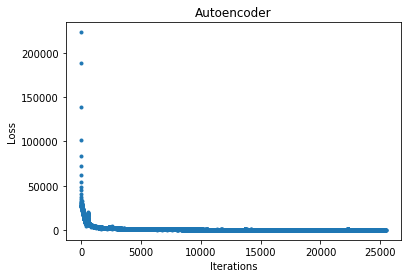

In [27]:
plt.plot(losses, '.')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Autoencoder")

Text(0.5, 1.0, 'Autoencoder')

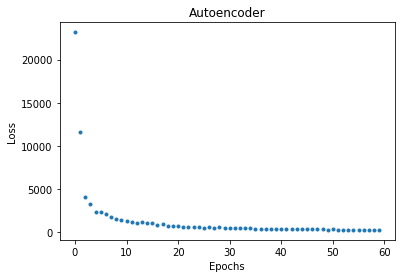

In [28]:
plt.plot([i for i in range(epochs_autoen)],  loss_ep, '.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Autoencoder")

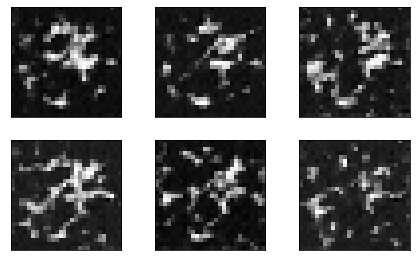

In [29]:
fixed_noise = torch.rand_like(z)
# fixed_noise = fixed_noise.view(-1, 28 * 28)
with torch.no_grad(): #??
    fixed_noisev = fixed_noise.to(DEVICE)

plot_results(decoder, fixed_noisev, 128, is_gray = True  )

In [30]:
x.shape

torch.Size([81, 1, 28, 28])

In [31]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder(x.to(DEVICE))
        z = z.cpu().detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.title('Encoding results')

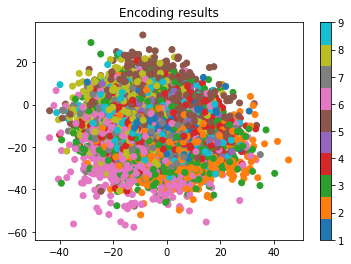

In [32]:
plot_latent(encoder, data_loader_autoen)

## 5. Distributions
### All samples are used

In [33]:
decoder = Decoder(hidden_dim = hidden_size).to(DEVICE)
encoder = Encoder(hidden_dim = hidden_size).to(DEVICE)

In [34]:
decoder.load_state_dict(torch.load(checkpoint_dir + "/decoder.pth")['state_dict'])
encoder.load_state_dict(torch.load(checkpoint_dir + "/encoder.pth")['state_dict'])

<All keys matched successfully>

In [35]:
encoder.eval()
decoder.eval()

Decoder(
  (model): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [36]:
# @torchsnooper.snoop()
def batch2one(Z, y, z):
    for i in range(y.shape[0]):
        Z[y[i]] = torch.cat((Z[y[i]], z[i]), dim=0) 
    return Z

# Z[0] contains all z samples with label 0, Z[1] contains all z samples with label and so on

In [37]:
def removing_line(array):
    A = []
    for i in range(len(array)):
        tmp = array[i]
        tmp = tmp[1:, :]
        A.append(tmp)
    return A
# deletes the first line which consists of zeros 

## Create distribution from randomly sampled events
Сохранение распределений для каждого класса. Из этих распределений будут потом генерироваться вектора в соответствии с классами для подачи на вход генератору.

In [38]:
Z = []
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
with torch.no_grad(): #?
    for i in range(class_num):
        Z.append(torch.zeros((1, latent_dims), dtype=torch.float).to(DEVICE)) 
    for i, (x, label) in enumerate(data_loader_autoen):
        x = x.to(DEVICE)
        z =  encoder(x.to(DEVICE))
        z = z.unsqueeze(1)
        Z = batch2one(Z, label, z)
        
    Z = removing_line(Z)

    N = []
    print('3rd cycle')

    for i in range(class_num): #############
        label_mean = torch.mean(Z[i][0:], dim=0)
        label_cov = torch.from_numpy(np.cov(Z[i][0:].cpu().numpy(), rowvar=False))


        label_mean = label_mean.to(DEVICE).float()
        label_cov = label_cov.to(DEVICE).float()        
        
        # regularisation
        X = np.random.multivariate_normal(mean=label_mean, cov=label_cov, size=25)
        cov = LedoitWolf().fit(X)
        
        label_mean = torch.tensor(cov.location_).float()
        label_cov = torch.tensor(cov.covariance_).float()
        
        #m = multivariate_normal(label_mean, label_cov)
        m = mn.MultivariateNormal(label_mean, label_cov)
        
        N.append(m)

torch.save({'distribution': N}, distribution_dir + '/class_distribution.dt')

3rd cycle


C:\Users\zaret\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: covariance is not positive-semidefinite.


In [39]:
def plotting(fake, image_size, label,  is_gray=True):
    generate_images = fake.cpu().detach().numpy()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(generate_images[i][0], cmap='gray', interpolation='none')### !!!!!!!
        plt.xticks([])
        plt.yticks([])
        plt.title(label)

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


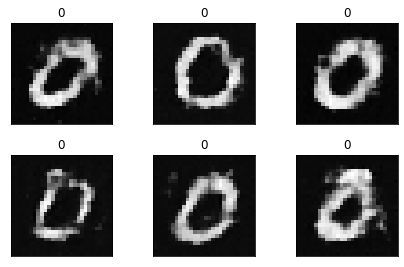

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


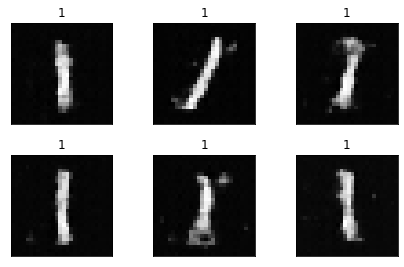

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


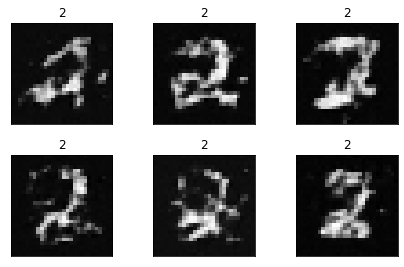

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


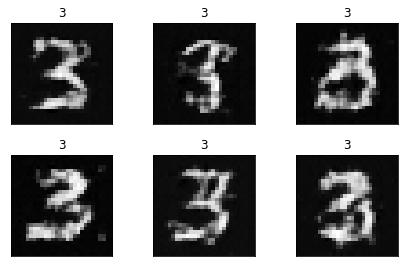

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


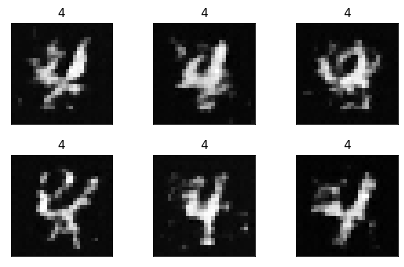

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


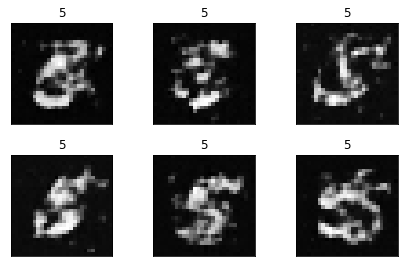

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


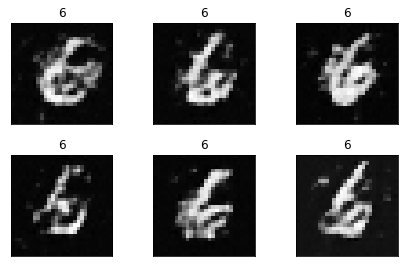

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


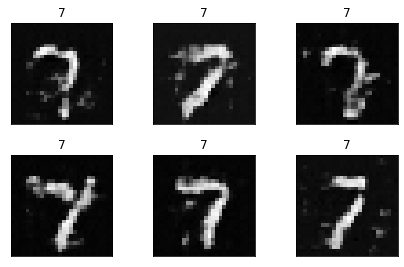

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


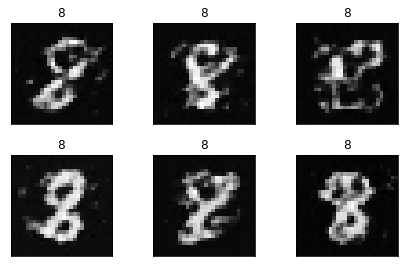

MultivariateNormal(loc: torch.Size([256]), covariance_matrix: torch.Size([256, 256]))


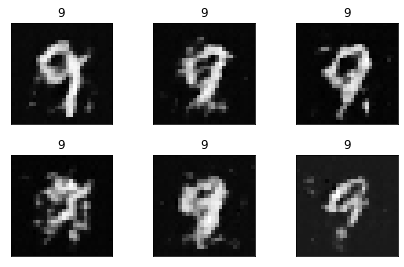

In [40]:
for i in range(class_num):
    print(N[i])
    samples = N[i].sample((6,))
    fake = decoder(samples.to(DEVICE))
    plotting(fake, 128, i)
    plt.show()

In [ ]:
#####

## 6. GAN
### The reduced dataset is used

In [41]:
distribution = torch.load(distribution_dir + '/class_distribution.dt')['distribution']

In [42]:
G = Decoder(hidden_dim = hidden_size).to(DEVICE)
D = Discriminator(hidden_dim = hidden_size).to(DEVICE)

In [43]:
G.load_state_dict(torch.load(checkpoint_dir + "/decoder.pth")['state_dict'])

<All keys matched successfully>

In [44]:
state_encoder = torch.load(checkpoint_dir + "/encoder.pth")['state_dict']

In [45]:
state_encoder.keys()

odict_keys(['model.0.weight', 'model.2.weight', 'model.3.weight', 'model.3.bias', 'model.3.running_mean', 'model.3.running_var', 'model.3.num_batches_tracked', 'model.5.weight', 'model.6.weight', 'model.6.bias', 'model.6.running_mean', 'model.6.running_var', 'model.6.num_batches_tracked', 'model.8.weight'])

In [46]:
D.model.load_state_dict(state_encoder)

<All keys matched successfully>

In [47]:
criterion = nn.CrossEntropyLoss().to(DEVICE) # for softmax

optimizerD = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))



In [48]:
D.train()
G.train()


Decoder(
  (model): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [49]:
real_label = torch.LongTensor(batch_size)
fake_label = torch.LongTensor(batch_size)

In [50]:
fixed_noise = torch.FloatTensor(batch_size, 2).normal_(0, 1) 
with torch.no_grad(): #??
    fixed_noisev = fixed_noise

In [51]:
## Генерация псевдослучайного вектора из latent-пространства 
## с использованием распределений для конкретных классов

def conditional_latent_generator(distribution, class_num, batch):
    class_labels = torch.randint(0, class_num, (batch,), dtype=torch.long)
    fake_z = distribution[class_labels[0].item()].sample((1,))
    for c in class_labels[1:]:
        fake_z = torch.cat((fake_z, distribution[c.item()].sample((1,))), dim=0)
    return fake_z, class_labels

tensor([3, 6, 5, 8, 5, 4])


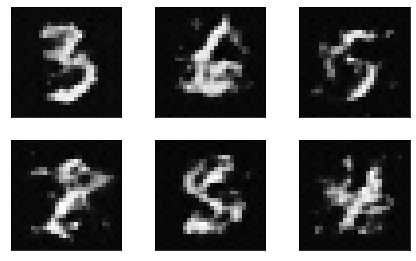

In [56]:
###################################
#Проверка работы:
decoder = Decoder(hidden_dim = hidden_size).to(DEVICE)
decoder.load_state_dict(torch.load(checkpoint_dir + "/decoder.pth")['state_dict'])

conditional_z, z_label = conditional_latent_generator(
    distribution, class_num, batch_size
)

plot_results(decoder, conditional_z.float(), 128, is_gray = True  )
print(z_label[:6])


###################################

In [57]:
loss_D = []
loss_G = []

epochs = 60


D_losses = []
G_losses = []
start_time = time.time()
for epoch in range(epochs):    
    for i, (x, label) in enumerate(data_loader): # reduced!

        x = x.to(DEVICE)
        label = label.to(DEVICE)
        
        for p in D.parameters():  
            p.requires_grad = True  
            
        # Update 'D' : max log(D(x)) + log(1-D(G(z)))
        batch_size = x.size(0)
        D.zero_grad()
        conditional_latent_generator
        
        # Training D with the real batch    
        D_real = D(x)
        real_label.resize_(batch_size).copy_(label)  #!
        D_loss_real = criterion(D_real, real_label.to(DEVICE))
        D_loss_real.backward()
        # Training D with the fake batch
        fake_num = math.ceil(batch_size/10)
        
        conditional_z, z_label = conditional_latent_generator(
            distribution, class_num, batch_size
        )
        
        noise = conditional_z[0:fake_num]
        fake_label.resize_(noise.shape[0]).fill_(10) # метка 10 для fake
        fake = G(noise.float())
        D_fake = D(fake.detach())        
        D_loss_fake = criterion(D_fake, fake_label.to(DEVICE))
        D_loss_fake.backward()
        # Computing
        D_loss = D_loss_real + D_loss_fake
        # Updating
        optimizerD.step()
        
        
        if i%5 == 0 and i!=0:
            for p in D.parameters():  
                p.requires_grad = False 
            G.zero_grad()
            ##
            conditional_z, z_label = conditional_latent_generator(
                distribution, class_num, batch_size
            )
            ##
            noise = conditional_z
            fake = G(noise.float())
            D_fake = D(fake)
            G_loss = criterion(D_fake, z_label.to(DEVICE)) 
            G_loss.backward()
            # Updating
            optimizerG.step()

            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
        
        if (i == len(data_loader_autoen) - 1): # per epoch 
            loss_D.append(D_loss.item())
            loss_G.append(G_loss.item())
        
        if epoch > 0 and i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss_G: {:.6f}'.format(
                epoch, i * len(x), len(data_loader.dataset),
                100. * i / len(data_loader), G_loss.item()))
            
        if epoch > 0 and i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss_D: {:.6f}'.format(
                epoch, i * len(x), len(data_loader.dataset),
                100. * i / len(data_loader), D_loss.item()))

            
            
    if epoch == 0:
        print("---1 epoch: %s seconds ---" % (time.time() - start_time))
        
        
torch.save({'epoch': epoch, 'state_dict': G.state_dict(),}, 
           checkpoint_dir +'/G.pth' )
torch.save({'epoch': epoch, 'state_dict': D.state_dict(),}, 
           checkpoint_dir +'/D.pth' )

---1 epoch: 61.55221080780029 seconds ---
Train Epoch: 1 [0/54225 (0%)]	Loss_G: 3.137698
Train Epoch: 1 [0/54225 (0%)]	Loss_D: 0.875411
Train Epoch: 1 [12800/54225 (24%)]	Loss_G: 2.128482
Train Epoch: 1 [12800/54225 (24%)]	Loss_D: 0.643521
Train Epoch: 1 [25600/54225 (47%)]	Loss_G: 2.086428
Train Epoch: 1 [25600/54225 (47%)]	Loss_D: 3.008005
Train Epoch: 1 [38400/54225 (71%)]	Loss_G: 4.754034
Train Epoch: 1 [38400/54225 (71%)]	Loss_D: 0.830129
Train Epoch: 1 [51200/54225 (94%)]	Loss_G: 5.528251
Train Epoch: 1 [51200/54225 (94%)]	Loss_D: 0.854630
Train Epoch: 2 [0/54225 (0%)]	Loss_G: 5.550138
Train Epoch: 2 [0/54225 (0%)]	Loss_D: 0.561960
Train Epoch: 2 [12800/54225 (24%)]	Loss_G: 2.720950
Train Epoch: 2 [12800/54225 (24%)]	Loss_D: 0.265406
Train Epoch: 2 [25600/54225 (47%)]	Loss_G: 2.944289
Train Epoch: 2 [25600/54225 (47%)]	Loss_D: 0.474253
Train Epoch: 2 [38400/54225 (71%)]	Loss_G: 2.858160
Train Epoch: 2 [38400/54225 (71%)]	Loss_D: 0.635498
Train Epoch: 2 [51200/54225 (94%)]	Loss_G:

Train Epoch: 17 [0/54225 (0%)]	Loss_G: 3.305324
Train Epoch: 17 [0/54225 (0%)]	Loss_D: 0.776793
Train Epoch: 17 [12800/54225 (24%)]	Loss_G: 2.257124
Train Epoch: 17 [12800/54225 (24%)]	Loss_D: 0.528361
Train Epoch: 17 [25600/54225 (47%)]	Loss_G: 2.241587
Train Epoch: 17 [25600/54225 (47%)]	Loss_D: 0.286451
Train Epoch: 17 [38400/54225 (71%)]	Loss_G: 5.344828
Train Epoch: 17 [38400/54225 (71%)]	Loss_D: 0.178629
Train Epoch: 17 [51200/54225 (94%)]	Loss_G: 7.025807
Train Epoch: 17 [51200/54225 (94%)]	Loss_D: 0.074575
Train Epoch: 18 [0/54225 (0%)]	Loss_G: 3.529292
Train Epoch: 18 [0/54225 (0%)]	Loss_D: 0.284685
Train Epoch: 18 [12800/54225 (24%)]	Loss_G: 5.494348
Train Epoch: 18 [12800/54225 (24%)]	Loss_D: 0.282166
Train Epoch: 18 [25600/54225 (47%)]	Loss_G: 4.993096
Train Epoch: 18 [25600/54225 (47%)]	Loss_D: 0.164947
Train Epoch: 18 [38400/54225 (71%)]	Loss_G: 4.875153
Train Epoch: 18 [38400/54225 (71%)]	Loss_D: 0.085921
Train Epoch: 18 [51200/54225 (94%)]	Loss_G: 7.686086
Train Epoch: 

Train Epoch: 32 [51200/54225 (94%)]	Loss_G: 4.017696
Train Epoch: 32 [51200/54225 (94%)]	Loss_D: 0.090624
Train Epoch: 33 [0/54225 (0%)]	Loss_G: 2.842272
Train Epoch: 33 [0/54225 (0%)]	Loss_D: 0.031869
Train Epoch: 33 [12800/54225 (24%)]	Loss_G: 3.115104
Train Epoch: 33 [12800/54225 (24%)]	Loss_D: 0.095499
Train Epoch: 33 [25600/54225 (47%)]	Loss_G: 4.032926
Train Epoch: 33 [25600/54225 (47%)]	Loss_D: 0.191447
Train Epoch: 33 [38400/54225 (71%)]	Loss_G: 6.968086
Train Epoch: 33 [38400/54225 (71%)]	Loss_D: 0.197142
Train Epoch: 33 [51200/54225 (94%)]	Loss_G: 2.789473
Train Epoch: 33 [51200/54225 (94%)]	Loss_D: 0.108742
Train Epoch: 34 [0/54225 (0%)]	Loss_G: 2.483595
Train Epoch: 34 [0/54225 (0%)]	Loss_D: 0.109427
Train Epoch: 34 [12800/54225 (24%)]	Loss_G: 5.704276
Train Epoch: 34 [12800/54225 (24%)]	Loss_D: 0.017156
Train Epoch: 34 [25600/54225 (47%)]	Loss_G: 4.922797
Train Epoch: 34 [25600/54225 (47%)]	Loss_D: 0.020453
Train Epoch: 34 [38400/54225 (71%)]	Loss_G: 2.257828
Train Epoch: 

Train Epoch: 48 [38400/54225 (71%)]	Loss_G: 9.308264
Train Epoch: 48 [38400/54225 (71%)]	Loss_D: 1.997836
Train Epoch: 48 [51200/54225 (94%)]	Loss_G: 2.615142
Train Epoch: 48 [51200/54225 (94%)]	Loss_D: 0.053003
Train Epoch: 49 [0/54225 (0%)]	Loss_G: 5.104595
Train Epoch: 49 [0/54225 (0%)]	Loss_D: 0.622630
Train Epoch: 49 [12800/54225 (24%)]	Loss_G: 6.414140
Train Epoch: 49 [12800/54225 (24%)]	Loss_D: 0.706169
Train Epoch: 49 [25600/54225 (47%)]	Loss_G: 6.297383
Train Epoch: 49 [25600/54225 (47%)]	Loss_D: 0.087365
Train Epoch: 49 [38400/54225 (71%)]	Loss_G: 1.640129
Train Epoch: 49 [38400/54225 (71%)]	Loss_D: 0.047194
Train Epoch: 49 [51200/54225 (94%)]	Loss_G: 2.731375
Train Epoch: 49 [51200/54225 (94%)]	Loss_D: 0.061589
Train Epoch: 50 [0/54225 (0%)]	Loss_G: 3.990324
Train Epoch: 50 [0/54225 (0%)]	Loss_D: 0.025927
Train Epoch: 50 [12800/54225 (24%)]	Loss_G: 5.771862
Train Epoch: 50 [12800/54225 (24%)]	Loss_D: 0.253065
Train Epoch: 50 [25600/54225 (47%)]	Loss_G: 6.348818
Train Epoch: 

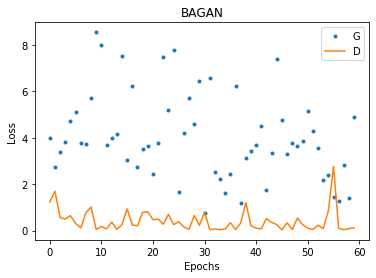

In [58]:
plt.plot([i for i in range(epochs)], loss_G, '.', label = 'G')
plt.plot([i for i in range(epochs)], loss_D, label = 'D')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("BAGAN")
plt.show()

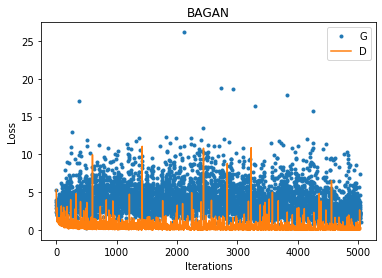

In [59]:
plt.plot(G_losses, '.', label='G')
plt.plot(D_losses,  label='D')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("BAGAN")
plt.show()

In [60]:
fixed_noise = torch.FloatTensor(batch_size, latent_dims).normal_(0, 1).to(DEVICE)

In [62]:
A, B = conditional_latent_generator(distribution, 1, batch_size)
A = A.float()

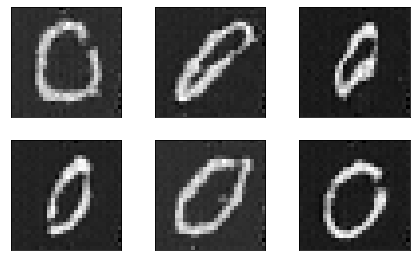

In [63]:
plot_results(G, A, 128, is_gray = True )
## синтезируются нули